# OBLIGATORIO 2 - BIG DATA SCIENCE

## DATA PREPARATION

In [102]:
%matplotlib inline 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pyspark
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.ml import Pipeline
from pyspark.sql import Row
from pyspark.sql import SQLContext
import math

#### Problema 1 - Data Analysis en Pandas

Cargando los datos de ACMETelephoneABT.csv en un Dataframe en pandas:

In [33]:
path_to_file = '/home/jovyan/work/Big_Data_Course_UM/Obligatorio_II/ACMETelephoneABT.csv'
pd_df = pd.read_csv(path_to_file)
cols = pd_df.columns
trimed = []
for name in cols:
    trimed.append(name.strip())
pd_df.columns = trimed
pd.set_option('display.max_columns', 500)
pd_df.head()

,customer,age,occupation,regionType,marriageStatus,children,income,numHandsets,handsetAge,smartPhone,currentHandsetPrice,creditRating,homeOwner,creditCard,avgBill,avgMins,avgrecurringCharge,avgOverBundleMins,avgRoamCalls,callMinutesChangePct,billAmountChangePct,avgReceivedMins,avgOutCalls,avgInCalls,peakOffPeakRatio,peakOffPeakRatioChangePct,avgDroppedCalls,lifeTime,lastMonthCustomerCareCalls,numRetentionCalls,numRetentionOffersAccepted,newFrequentNumbers,churn
0,1000004,26,crafts,town,yes,true,6,1,1812,false,0.00,C,true,true,38.00,7.50,38.00,0.00,0.00,-0.030,0.0000,0.41,0.33,0.00,0.362398,-6.330770,0.00,60,0.00,0,0,0,false
1,1000012,36,,,yes,true,9,4,544,true,79.99,A,false,true,35.30,24.25,34.98,0.00,0.00,0.395,-0.0062,2.39,4.00,1.67,5.586826,7.499560,0.00,53,0.00,0,0,0,false
2,1000034,74,professional,town,yes,false,7,2,138,true,29.99,A,false,true,21.15,45.50,16.99,14.00,0.00,-0.310,-0.0832,2.28,0.00,0.33,0.500000,-5.940493,4.33,58,0.00,0,0,3,false
3,1000063,30,,suburban,no,false,6,3,122,true,9.99,C,false,true,91.18,332.75,75.00,0.00,0.00,-0.615,-0.1084,33.21,9.00,4.67,8.629661,-0.066485,5.33,50,0.33,0,0,0,false
4,1000085,32,,town,yes,false,7,8,10,true,129.99,A,false,true,93.02,1348.25,75.00,4.75,1.92,-3.305,0.4930,436.53,59.33,23.00,14.042685,-7.208502,14.67,56,0.00,0,0,0,false


In [51]:
pd_df.creditCard.unique()

array([' true', ' false', ' no', ' t', ' f', ' yes'], dtype=object)

In [52]:
pd_df.creditRating.unique()

array([' C', ' A', ' D', ' E', ' G', ' B', ' F'], dtype=object)

Se puede ver que datos contienen espacios en ellos y creditCard tiene booleans con muchos valores.

In [74]:
objcols =  pd_df.columns.to_series().groupby(pd_df.dtypes).groups
objcols = {k.name: v for k, v in objcols.items()}
objcols = list(objcols['object'])

pd_df[objcols] = pd_df[objcols].applymap(lambda x: x.strip())
pd_df.creditRating.unique()

array(['C', 'A', 'D', 'E', 'G', 'B', 'F'], dtype=object)

In [75]:
def various_to_TF(various):
    res = -1
    if various.lower() in ['true', 't', 'yes', 'y']:
        res = True
    else:
        res = False
    return res

In [76]:
pd_df['creditCard'] = pd_df['creditCard'].apply(various_to_TF)
pd_df.creditCard.unique()

array([True, False], dtype=object)

###### 1. Usando el método describe, crear un Data Quality Report.

In [77]:
pd_df.describe(include=[np.number])

,customer,age,income,numHandsets,handsetAge,currentHandsetPrice,avgBill,avgMins,avgrecurringCharge,avgOverBundleMins,avgRoamCalls,callMinutesChangePct,billAmountChangePct,avgReceivedMins,avgOutCalls,avgInCalls,peakOffPeakRatio,peakOffPeakRatioChangePct,avgDroppedCalls,lifeTime,lastMonthCustomerCareCalls,numRetentionCalls,numRetentionOffersAccepted,newFrequentNumbers
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.049974e+06,30.318400,4.293600,1.804500,390.171700,35.730696,58.927600,521.170645,46.236537,42.392670,1.186048,-0.280848,-0.003595,115.266619,25.208834,8.368029,2.217785,-0.046749,9.992283,18.836300,1.737414,0.044600,0.020700,0.195000
std,2.879841e+04,22.158676,3.139902,1.345088,257.076656,57.072922,43.889815,540.435285,23.964960,106.374374,6.048811,5.231031,0.762955,169.979443,35.665714,17.676847,3.882714,9.973846,14.859162,9.610928,5.754564,0.225867,0.155158,0.641261
min,1.000001e+06,0.000000,0.000000,1.000000,-5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-50.355000,-7.600400,0.000000,0.000000,0.000000,0.000000,-41.322736,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000
25%,1.025200e+06,0.000000,0.000000,1.000000,210.000000,0.000000,33.327500,150.627500,30.000000,0.000000,0.000000,-1.725000,-0.132600,7.690000,3.000000,0.000000,0.779357,-6.791049,1.670000,11.000000,0.000000,0.000000,0.000000,0.000000
50%,1.049833e+06,34.000000,5.000000,1.000000,339.000000,0.000000,49.205000,359.625000,44.990000,3.000000,0.000000,-0.100000,-0.005200,52.540000,13.330000,2.000000,1.399874,0.011607,5.330000,17.000000,0.000000,0.000000,0.000000,0.000000
75%,1.074990e+06,48.000000,7.000000,2.000000,525.000000,59.990000,71.762500,709.187500,59.990000,43.750000,0.260000,1.300000,0.042600,154.382500,33.330000,9.000000,2.494232,6.494723,12.670000,24.000000,1.330000,0.000000,0.000000,0.000000
max,1.099988e+06,98.000000,9.000000,21.000000,1812.000000,499.990000,584.230000,6336.250000,337.980000,4320.750000,177.990000,50.425000,17.911400,2006.290000,610.330000,304.000000,160.000000,37.779743,304.670000,61.000000,365.670000,4.000000,4.000000,3.000000


In [78]:
pd_df.describe(include=[object])

,occupation,regionType,marriageStatus,children,smartPhone,creditRating,homeOwner,churn
count,10000,10000,10000,10000,10000,10000,10000,10000
unique,8,8,3,2,2,7,2,2
top,,,unknown,false,true,B,false,false
freq,7400,4776,3920,7559,9015,3785,6577,5000


###### 2. Determinar para cada atributo su tipo (i.e. ordinal, categórico, etc)

In [50]:
pd_df.convert_objects
pd_df.dtypes

customer                        int64
age                             int64
occupation                     object
regionType                     object
marriageStatus                 object
children                       object
income                          int64
numHandsets                     int64
handsetAge                      int64
smartPhone                     object
currentHandsetPrice           float64
creditRating                   object
homeOwner                      object
creditCard                     object
avgBill                       float64
avgMins                       float64
avgrecurringCharge            float64
avgOverBundleMins             float64
avgRoamCalls                  float64
callMinutesChangePct          float64
billAmountChangePct           float64
avgReceivedMins               float64
avgOutCalls                   float64
avgInCalls                    float64
peakOffPeakRatio              float64
peakOffPeakRatioChangePct     float64
avgDroppedCa

Todos los int64 y float64 son numéricos.
Los que son object:
occupation                    Categorical
regionType                    Categorical
marriageStatus                Boolean
children                      Boolean
smartPhone                    Boolean
creditRating                  Ordinal
homeOwner                     Boolean
creditCard                    object
churn                         object

###### 3.Usando el m ́etodo corr() de Pandas, identificar los 3 pares de atributos con mayor correlación (usar Pearson como métrica).

corr = pd_df.corr(method='pearson')

In [82]:
corr

,customer,age,income,numHandsets,handsetAge,currentHandsetPrice,avgBill,avgMins,avgrecurringCharge,avgOverBundleMins,avgRoamCalls,callMinutesChangePct,billAmountChangePct,avgReceivedMins,avgOutCalls,avgInCalls,peakOffPeakRatio,peakOffPeakRatioChangePct,avgDroppedCalls,lifeTime,lastMonthCustomerCareCalls,numRetentionCalls,numRetentionOffersAccepted,newFrequentNumbers
customer,1.000000,-0.117682,-0.134630,-0.261656,-0.419970,-0.030507,0.006476,0.094690,0.060883,-0.002703,0.015770,-0.004407,-0.001350,0.054830,0.046272,0.038587,-0.123676,-0.001946,0.068565,-0.752537,0.092704,-0.058963,-0.045458,-0.008781
age,-0.117682,1.000000,0.665303,-0.012326,0.120619,-0.044271,-0.099618,-0.141152,-0.110412,-0.046321,-0.029106,0.008715,-0.009873,-0.121843,-0.126774,-0.099762,0.041059,-0.000112,-0.088091,0.123912,-0.062742,-0.011150,-0.007270,0.003724
income,-0.134630,0.665303,1.000000,-0.026427,0.134935,-0.041015,-0.085928,-0.142944,-0.084591,-0.045467,-0.024151,0.002837,-0.019343,-0.126500,-0.111885,-0.104544,0.065670,-0.000509,-0.100520,0.138451,-0.090742,-0.012825,-0.004060,0.011945
numHandsets,-0.261656,-0.012326,-0.026427,1.000000,-0.359943,0.542411,0.258255,0.303252,0.240720,0.162580,0.014863,-0.028437,-0.011218,0.274293,0.257173,0.259905,0.008845,-0.010108,0.213288,0.363029,0.094164,0.111986,0.097503,0.020085
handsetAge,-0.419970,0.120619,0.134935,-0.359943,1.000000,-0.428018,-0.241876,-0.323110,-0.264443,-0.130113,-0.037326,-0.006513,-0.011473,-0.259274,-0.245505,-0.207028,0.108937,-0.004046,-0.233402,0.481136,-0.144866,-0.029746,-0.031145,-0.010463
currentHandsetPrice,-0.030507,-0.044271,-0.041015,0.542411,-0.428018,1.000000,0.238746,0.281855,0.223835,0.136505,0.011553,0.002259,0.007433,0.251663,0.253109,0.228867,-0.032385,-0.004159,0.186527,0.036979,0.098189,0.073014,0.068240,0.003733
avgBill,0.006476,-0.099618,-0.085928,0.258255,-0.241876,0.238746,1.000000,0.727535,0.631075,0.780485,0.244663,-0.020326,0.012216,0.625518,0.517503,0.416616,0.000308,-0.003148,0.445601,-0.018345,0.142319,0.017435,0.010886,-0.003987
avgMins,0.094690,-0.141152,-0.142944,0.303252,-0.323110,0.281855,0.727535,1.000000,0.575358,0.581635,0.117649,-0.051441,-0.016847,0.835479,0.707246,0.590484,-0.084473,0.005397,0.581539,-0.083280,0.308847,0.010349,0.009802,0.003470
avgrecurringCharge,0.060883,-0.110412,-0.084591,0.240720,-0.264443,0.223835,0.631075,0.575358,1.000000,0.187628,0.069146,-0.027488,-0.017510,0.472973,0.407312,0.324194,0.011824,-0.007505,0.326137,-0.066327,0.118531,-0.020771,-0.003877,-0.002368
avgOverBundleMins,-0.002703,-0.046321,-0.045467,0.162580,-0.130113,0.136505,0.780485,0.581635,0.187628,1.000000,0.082605,-0.008864,0.014117,0.511599,0.421084,0.333874,-0.009022,0.005827,0.355084,0.006229,0.098812,0.013022,0.005083,-0.001153


In [7]:
type(corr)

pandas.core.frame.DataFrame

In [86]:
a = corr.abs()

list_abs = a.unstack()
list_abs.sort_values(inplace=True)

In [95]:
tot = len(list_abs)
list_abs[-34:-24]

numRetentionOffersAccepted  numRetentionCalls             0.718484
numRetentionCalls           numRetentionOffersAccepted    0.718484
avgBill                     avgMins                       0.727535
avgMins                     avgBill                       0.727535
lifeTime                    customer                      0.752537
customer                    lifeTime                      0.752537
avgBill                     avgOverBundleMins             0.780485
avgOverBundleMins           avgBill                       0.780485
avgMins                     avgReceivedMins               0.835479
avgReceivedMins             avgMins                       0.835479
dtype: float64

Max correlation pairs:
customer                    lifeTime                      0.752537
avgOverBundleMins           avgBill                       0.780485
avgReceivedMins             avgMins                       0.835479

##### 4. Para estos 3 pares de atributos, crear una gráfica de correlación y distribución usando el paquete seaborn.

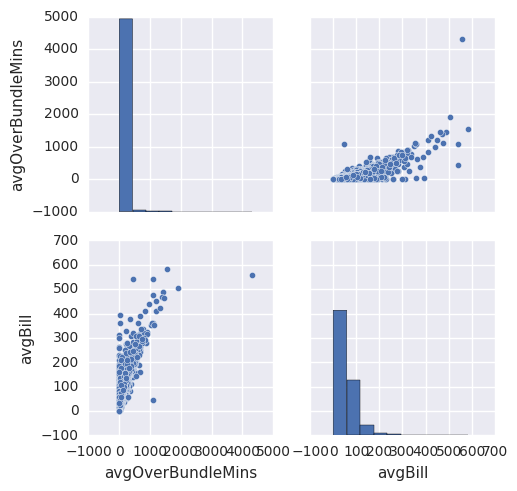

In [79]:
sns.pairplot(pd_df[["avgReceivedMins", "avgMins"]])

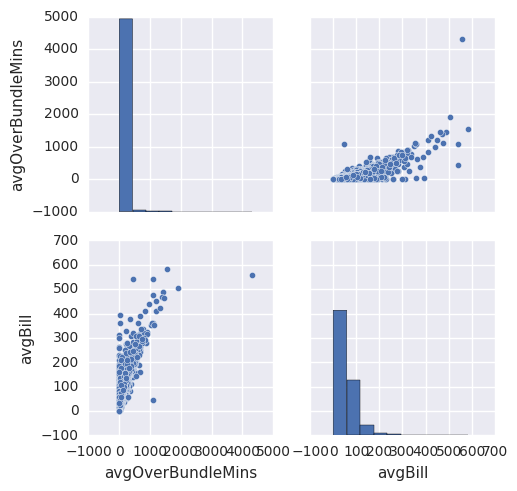

In [79]:
sns.pairplot(pd_df[["avgOverBundleMins", "avgBill"]])

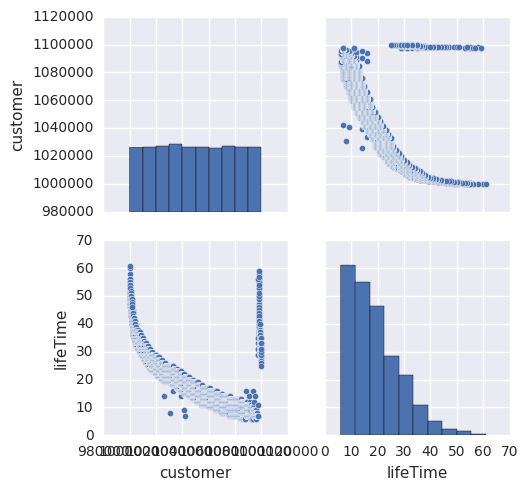

In [80]:
sns.pairplot(pd_df[["customer", "lifeTime"]])

##### 5. Crear boxplots para los atributos lifeTime, age (en la misma gráfica). Solamente mirando estas gráficas escriba todas las conclusiones que uno puede sacar de estos datos.

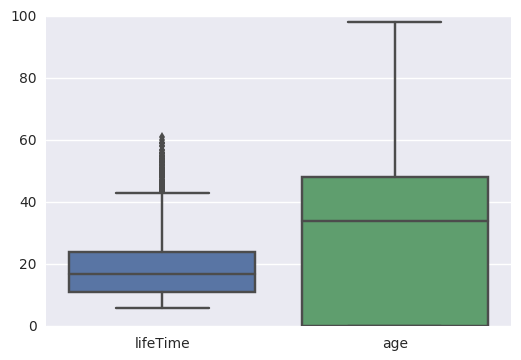

In [97]:
sns.boxplot(data=pd_df[["lifeTime","age"]])

LifeTime:
Range ~= 61 - 6 = 55
Min ~= 6    Max~=61
Quartiles:
1: 6-12
2: 13-16
3: 17-22
4: 23-41
Outliers:
41-61
Media ~= 16


age:
Range ~= 98 - 0 = 98
Min ~= 0    Max~=98
Quartiles:
1: 0-0
2: 0-34
3: 35-44
4: 45-98
Media ~= 34

Podemos ver que hay >= del 25% de las edades con valor 0, seguramente este valor signifique que no se ingresó la misma.

##### 6. Crear gráficas de densidad (KDE) para los atributos avgMins y avgOutCalls (con y sin usar escala logarítmica) ¿Qué distribución cree usted que sigue av-gOutCalls ?

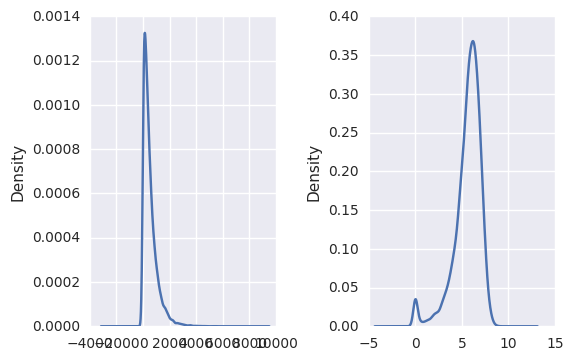

In [106]:
fig, axes = plt.subplots(nrows=1, ncols=2)

plt.subplots_adjust(wspace=0.5, hspace=0.5);

pd_df["avgMins"].plot(kind = "kde", ax=axes[0]);

(pd_df.avgMins + 1).apply(math.log).plot(kind = "kde", ax=axes[1]);

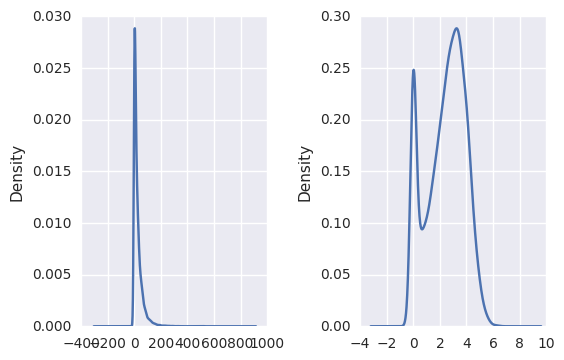

In [107]:
fig, axes = plt.subplots(nrows=1, ncols=2)

plt.subplots_adjust(wspace=0.5, hspace=0.5);

pd_df["avgOutCalls"].plot(kind = "kde", ax=axes[0]);

(pd_df.avgOutCalls + 1).apply(math.log).plot(kind = "kde", ax=axes[1]);

AvgOutCalls tiene una distribución normal multimodal.

##### 7. Utilizando avgMins y avgOutCalls:

a) Normalizar usando como valor máximo 2 desviaciones estándar de la media en nuevas columnas. Guardar los resultado en nuevas columna, avgMinsNorm y avgOutCallsNorm.

In [120]:
desc = pd_df[["avgMins","avgOutCalls"]].describe(include=[np.number])
desc

,avgMins,avgOutCalls
count,10000.000000,10000.000000
mean,521.170645,25.208834
std,540.435285,35.665714
min,0.000000,0.000000
25%,150.627500,3.000000
50%,359.625000,13.330000
75%,709.187500,33.330000
max,6336.250000,610.330000


In [128]:
def norm_2_std(value, min_val, std, mean):
    return float(value)/(mean + 2*std - min_val)

In [131]:
pd_df["avgMinsNorm"] = pd_df["avgMins"].apply(lambda x: norm_2_std(x, desc.avgMins['min'], desc.avgMins['std'], desc.avgMins['mean']))
pd_df["avgOutCallsNorm"] = pd_df["avgOutCalls"].apply(lambda x: norm_2_std(x, desc.avgOutCalls['min'], desc.avgOutCalls['std'], desc.avgOutCalls['mean']))

In [134]:
pd_df[["avgMins", "avgMinsNorm", "avgOutCalls", "avgOutCallsNorm"]].head()

,avgMins,avgMinsNorm,avgOutCalls,avgOutCallsNorm
0,7.50,0.004682,0.33,0.003418
1,24.25,0.015137,4.00,0.041433
2,45.50,0.028401,0.00,0.000000
3,332.75,0.207704,9.00,0.093225
4,1348.25,0.841583,59.33,0.614562


b) Graficar los histogramas de estas distribuciones.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fab1ae09310>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fab1b11d3d0>]], dtype=object)

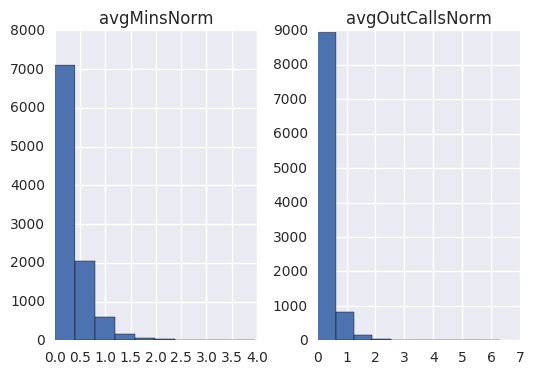

In [136]:
pd_df[["avgMinsNorm", "avgOutCallsNorm"]].hist()

c) Investigar sobre la estadística de kolmogorov-smirnov y determinar si estos valores siguen una misma distribución.

d) Usando la funci ́on apply() de pandas, discretizar la columna avgMins en 5

bins distintos usando:

1) igual frecuencia.

In [163]:
pd_df["avgMins_disc_f"] = pd.qcut(pd_df["avgMins"].tolist(),5)
pd_df[["avgMins","avgMins_disc_f"]].head()

,avgMins,avgMins_disc_f
0,7.50,"[0, 116]"
1,24.25,"[0, 116]"
2,45.50,"[0, 116]"
3,332.75,"(269.65, 474.25]"
4,1348.25,"(827.1, 6336.25]"


2) igual ancho.

In [164]:
pd_df["avgMins_disc_w"] = pd.cut(pd_df["avgMins"].tolist(),5)
pd_df[["avgMins","avgMins_disc_w"]].head()

,avgMins,avgMins_disc_w
0,7.50,"(-6.336, 1267.25]"
1,24.25,"(-6.336, 1267.25]"
2,45.50,"(-6.336, 1267.25]"
3,332.75,"(-6.336, 1267.25]"
4,1348.25,"(1267.25, 2534.5]"


##### 8. Crear una muestra del dataset entero para reducir el tamaño a un 20 % usando:

a) muestra aleatoria.


In [169]:
df_random_sample = pd_df.sample(frac=0.2)
df_random_sample.shape

(2000, 37)